## Общее описание:

В ходе проведения эксперимента тестировалась новая механика оплаты услуг на сайте. Целевой группе была предложена новая механика, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги A/B теста и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Описание данных

В качестве входных данных имеются 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### План

1. **Загружаем данные:**
    - Напишем функцию для считывания данных
    - Загрузим данные
    
    
2. **Посмотрим на данные:**
    - Узнаем размер, тип данных
    - Выполним проверку на пропущенные значения, на дубликаты


3. **Предобработаем данные**
    - Выполним необходимые джойны


4. **Определяем целевые метрики**
    - Выберем метрики для оценки эксперимента
    - Посчитаем их


5. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
     
     
6. **Подводим итоги:**
    - Сформулируем выводы
    
    
7. **Автоматизируем рутину**
    - Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
    - Реализуем функцию, которая будет строить графики по получаемым метрикам.

## 1: загружаем данные

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss

import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
# объявим функцию для считывания данных с Яндекс.Диска
def get_data(public_key, sep=';'):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    df = pd.read_csv(download_url, sep=sep, error_bad_lines=False, comment='#')
    
    return df

In [3]:
# ссылки на файлы на Яндекс.Диске
groups_public_key = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
group_add_public_key = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_public_key = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_public_key = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [4]:
# считываем данные
groups = get_data(groups_public_key)
group_add = get_data(group_add_public_key, sep=',')
active_studs = get_data(active_studs_public_key)
checks = get_data(checks_public_key)

## 2: смотрим на данные 
Размер датафреймов, тип данных, пропущенные значения

In [5]:
# объявим функцию для проверки наших данных
def check_data(df):
    '''Принимает датафрейм, выводит информацию о количестве строк и столбцов в нем, типы данных, 
    количество пропущенных значений, а также имена колонок, в которых встречаются повторяющиеся значения'''
    
    rows = df.shape[0]
    columns = df.shape[1]
    
    print(f'Количество строк: {rows}', f'Количество столбцов: {columns}', sep='\n', end='\n\n')
    print('Типы данных:', df.dtypes, sep='\n', end='\n\n')
    print('Пропущенные значения:', df.isna().sum(), sep='\n', end='\n\n')
    
    cols_with_duplicates = []
    cols = df.columns
    for i in range(columns):
        if df.iloc[:, i].nunique() == rows:
            continue
        else:
            cols_with_duplicates.append(cols[i])
    print(f'Колонки, в которых встречаются повторяющиеся значения: {cols_with_duplicates}')
    
    return df.head()

In [6]:
check_data(groups)

Количество строк: 74484
Количество столбцов: 2

Типы данных:
id      int64
grp    object
dtype: object

Пропущенные значения:
id     0
grp    0
dtype: int64

Колонки, в которых встречаются повторяющиеся значения: ['grp']


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
check_data(group_add)

Количество строк: 92
Количество столбцов: 2

Типы данных:
id      int64
grp    object
dtype: object

Пропущенные значения:
id     0
grp    0
dtype: int64

Колонки, в которых встречаются повторяющиеся значения: ['grp']


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
check_data(active_studs)

Количество строк: 8341
Количество столбцов: 1

Типы данных:
student_id    int64
dtype: object

Пропущенные значения:
student_id    0
dtype: int64

Колонки, в которых встречаются повторяющиеся значения: []


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [9]:
check_data(checks)

Количество строк: 541
Количество столбцов: 2

Типы данных:
student_id      int64
rev           float64
dtype: object

Пропущенные значения:
student_id    0
rev           0
dtype: int64

Колонки, в которых встречаются повторяющиеся значения: ['rev']


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [10]:
checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


In [11]:
checks.rev.sum()

573326.0035999999

## 3: препроцессинг данных

In [12]:
# переименуем колонки с id пользователей идентично для всех файлов
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

In [13]:
# объединяем ДФ с информацией о принадлежности пользователя к той или иной группе
groups_full = pd.concat([groups, group_add], axis=0)

In [14]:
groups_full.id.nunique() == groups_full.shape[0]
# после объединения ДФ дубликатов нет

True

In [15]:
# формируем итоговый ДФ с результатами эксперимента
# для анализа оставляем только тех польз-лей, которые заходили на платфоруму в дни эксперимента (active_studs)
exp_results = active_studs \
    .merge(checks, how='left', on='id') \
    .merge(groups_full, how='inner', on='id')

In [16]:
# проверили, что итоговый ДФ содержит всех польз-лей, заходивших на платформу в дни эксперимента
exp_results.id.nunique()

8341

In [17]:
exp_results.rev.sum()
# сумма выручки не сходится с файлом checks

467794.00350000005

In [18]:
# проверим, какие польз-ли есть в checks, но нет в active_studs. Создадим столбец active и присвоим лейбл "yes"
active_studs['active'] = 'yes'

In [19]:
checks.merge(active_studs, how='left', on='id').query('active != "yes"')
# странно, но есть 149 польз-лей, которые не заходили на платформу, но у которых есть покупки
# возможно, при сборе данных или логировании польз-лей была допущена ошибка
# поскольку это 1,7% от общего объема выборки (8341), мы не будем включать их в анализ 

,id,rev,active
1,3185,690.0,NaN
2,25973,690.0,NaN
3,26280,690.0,NaN
5,100645,630.0,NaN
6,102534,580.0,NaN
...,...,...,...
508,5291900,199.0,NaN
512,5331842,290.0,NaN
521,5486319,199.0,NaN
530,5562806,398.0,NaN


In [20]:
exp_results.head()

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


## 4: метрики

In [21]:
# посмотрим на размеры групп
exp_results.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [22]:
# исходя из имеющихся данных, в качестве целевых метрик используем ср.чек и конверсию в покупку
# посчитаем их отдельно для каждой группы
metrics = exp_results \
    .groupby('grp', as_index=False) \
    .agg({'rev': 'sum'})
metrics

,grp,rev
0,A,72820.0000
1,B,394974.0035


In [23]:
# кол-во покупателей по группам
clients = exp_results \
    .query('rev > 0') \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'clients'})
clients

,grp,clients
0,A,78
1,B,314


In [24]:
# кол-во польз-лей по группам
users = exp_results \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'users'})
users

,grp,users
0,A,1538
1,B,6803


In [25]:
metrics = metrics.merge(clients).merge(users)

In [26]:
# считаем конверсию в покупку по группам
metrics['cr'] = metrics.clients / metrics.users

In [27]:
# считаем ср.чек по группам
metrics['avg_check'] = metrics.rev / metrics.clients

In [28]:
metrics
# конверсия в покупку выше у польз-лей из группы А, а ср.чек выше у польз-лей из группы В

,grp,rev,clients,users,cr,avg_check
0,A,72820.0000,78,1538,0.050715,933.589744
1,B,394974.0035,314,6803,0.046156,1257.878992


In [29]:
# чтобы понять, в какой группе мы все-таки зарабатываем больше с каждого польз-ля, посчитаем ARPU
metrics['arpu'] = metrics.rev / metrics.users

In [30]:
metrics
# несмотря на снижение конверсии, больше зарабатываем на польз-лях из группы B

,grp,rev,clients,users,cr,avg_check,arpu
0,A,72820.0000,78,1538,0.050715,933.589744,47.347204
1,B,394974.0035,314,6803,0.046156,1257.878992,58.058798


In [31]:
metrics.iloc[1]['avg_check'] / metrics.iloc[0]['avg_check']
# ср.чек у польз-лей из группы В на 35% больше, чем у группы А 

1.3473573383545858

In [32]:
1 - metrics.iloc[1]['cr'] / metrics.iloc[0]['cr']
# конверсия у польз-лей из группы В на 9% ниже, чем у группы А

0.08989623733119256

In [33]:
# с помощью статистических методов проверим, являются ли данные различия стат.значимыми

## 5: проверка гипотез

In [34]:
# Проверим распределения на нормальность

In [35]:
control = exp_results.query('grp == "A"').dropna()

<AxesSubplot:>

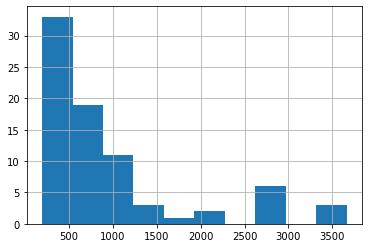

In [36]:
# распределение суммы покупок в группе А
control.rev.hist()

In [37]:
test = exp_results.query('grp == "B"').dropna()

<AxesSubplot:>

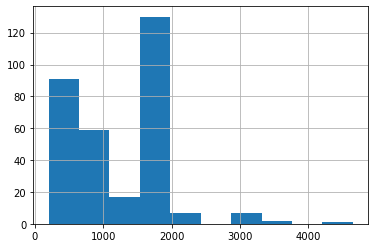

In [38]:
# распределение суммы покупок в группе В
test.rev.hist()

In [39]:
# на гистограммах оба распределения не выглядят нормальными

<AxesSubplot:xlabel='grp', ylabel='rev'>

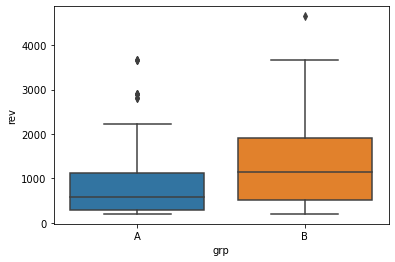

In [40]:
# Boxplot по сумме покупок для каждой группы
sns.boxplot(x="grp", y="rev", data=exp_results.query('rev > 0'))

In [41]:
# делать вывод только по графику не очень хорошо. Проверим распределения на нормальность с помощью статистического теста

In [42]:
test.shape

(314, 3)

In [43]:
control.shape

(78, 3)

In [44]:
# размер выборок небольшой, можем применить тест Шапиро-Уилка без сэмплирования

In [45]:
ss.shapiro(test.rev)
# H0 - распределение значимо не отличается от нормального.
# Н1 - распределение значимо отличается от нормального.
# Т.к. pvalue < 0.05, мы отклоняем Н0 => тест на нормальность НЕ пройден

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

In [46]:
ss.shapiro(control.rev)
# H0 - распределение значимо не отличается от нормального.
# Н1 - распределение значимо отличается от нормального.
# Т.к. pvalue < 0.05, мы отклоняем Н0 => тест на нормальность НЕ пройден

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

Распределения не являются нормальными, кроме того у нас небольшое количество наблюдений в группе А (control)
Поэтому для проверки равенства распределений используем непараметрический критерий Манна-Уитни:

**Нулевая гипотеза (H0)**: распределения суммы покупок в тестовой и контрольной группе равны

**Альтернативная гипотеза (H1)**: распределения суммы покупок в тестовой и контрольной группе не равны 

In [47]:
Mann_Whitney = ss.mannwhitneyu(test.rev, control.rev)
Mann_Whitney

MannwhitneyuResult(statistic=9001.0, pvalue=0.0001255696915703461)

In [48]:
# p-value < 0.05 => отклоняем Н0 о том, что распределения суммы покупок в тестовой и контрольной группе равны

Для понимания того, как именно различаются распределения, воспользуемся бутстрапом. Поскольку распределения не являются нормальными и имеют выбросы, будем сравнивать разность сумм покупок в двух группах по медиане.

Сформулируем гипотезы для проверки различий в суммах покупок.

**Нулевая гипотеза (H0)**: Разницы между суммами покупок в тестовой и контрольной группе нет

**Альтернативная гипотеза (H1)**: Разница между суммами покупок в тестовой и контрольной группе есть

In [49]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

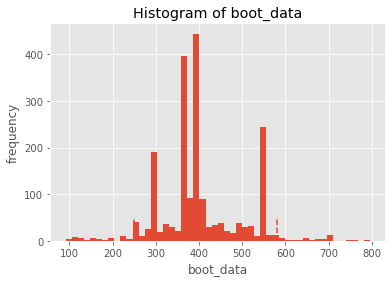

In [70]:
# применяем бутстрап (с np.median) на исходных данных
bootstrap_median = get_bootstrap(test.rev, control.rev, boot_it=2000)

In [71]:
bootstrap_median['p_value']

2.098299546045922e-05

In [72]:
bootstrap_median['ci']

,0
0.025,250.0
0.975,580.0


In [53]:
# p-value < 0.05, доверительный интервал не включает в себя 0 => принимаем Н1 о том, что разница между средним чеком 
# в тестовой и контрольной группе есть

Теперь сформулируем гипотезы для проверки конверсии.
Поскольку мы имеем две категориальные переменные (купил / не купил, А / В), нужен хи-квадрат

**Нулевая гипотеза (H0)**: взаимосвязи между переменными нет

**Альтернативная гипотеза (H1)**: взаимосвязь есть

In [54]:
# добавим столбец "купил / не купил"
exp_results['buy'] = exp_results.rev > 0

In [55]:
exp_results.tail()

,id,rev,grp,buy
8336,1794344,NaN,B,False
8337,296883,NaN,B,False
8338,3598448,NaN,B,False
8339,3610547,290.0,B,True
8340,205705,NaN,B,False


In [56]:
pd.crosstab(exp_results.grp, exp_results.buy)

buy,False,True
grp,,
A,1460,78
B,6489,314


In [57]:
# применяем хи-квадрат на наших данных
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(exp_results.grp, exp_results.buy))

In [58]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [59]:
prob = 0.95
critical = ss.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [60]:
# принимаем Н0 о том, что взаимосвязи между переменными нет

## 6: выводы

1. ср.чек у польз-лей из группы В (тест) выше, чем у польз-лей из группы А (контроль). В наших выборках ср.чек в группе В на 35% выше, чем в группе А
2. конверсия в покупку не показала стат.значимых различий между группами
3. если мы в достаточной степени уверены в репрезентативности нашей выборки, а также исключили влияние других факторов на результаты эксперимента, то можем признать эксперимент удачным и запускать новую механику оплаты на всех пользователей

Также следует отметить, что есть 149 польз-лей, которые не заходили на платформу, но у которых есть покупки. Возможно, при сборе данных или логировании польз-лей была допущена ошибка. Необходимо дополнительно проверить причины возникновения ошибки.

## 7: пишем функцию для автоматической загрузки доп.файла

In [63]:
def add_data(groups, group_add_public_key, active_studs, checks):
    '''Принимает датафреймы:
    groups - принадлежность пользователя к контрольной или экспериментальной группе,
    active_studs - пользователи, которые зашли на платформу в дни проведения эксперимента,
    checks - оплаты пользователей в дни проведения эксперимента,
    group_add_public_key - ссылка для скачивания дополнительного файла с пользователями.
    Возвращает таблицу с пересчитанными метриками с учетом данных из доп. файла'''
    
    # считываем данные из доп.файла
    group_add = get_data(group_add_public_key, sep=',') 
    
    # переименуем колонки с id пользователей идентично для всех файлов
    group_add.rename(columns={group_add.columns[0]: 'id', group_add.columns[1]: 'grp'}, inplace=True)
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)

    # добавляем доп.данные к уже имеющимся данным по группам польз-лей
    groups_full = pd.concat([groups, group_add], axis=0)
    groups_full.drop_duplicates(subset='id', inplace=True)
    
    # формируем итоговый ДФ с результатами эксперимента
    exp_results = active_studs \
        .merge(checks, how='left', on='id') \
        .merge(groups_full, how='inner', on='id')
    exp_results['buy'] = exp_results.rev > 0
    
    # пересчитываем метрики
    metrics = exp_results \
        .groupby('grp', as_index=False) \
        .agg({'rev': 'sum'})
    
    clients = exp_results \
        .query('rev > 0') \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count'}) \
        .rename(columns={'id': 'clients'})
    
    users = exp_results \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count'}) \
        .rename(columns={'id': 'users'})
    metrics = metrics.merge(clients).merge(users)
    
    metrics['cr'] = metrics.clients / metrics.users
    metrics['avg_check'] = metrics.rev / metrics.clients
    metrics['arpu'] = metrics.rev / metrics.users
    
    return metrics

In [64]:
metrics_new = add_data(groups_full, group_add_public_key, active_studs, checks)

In [65]:
metrics_new

,grp,rev,clients,users,cr,avg_check,arpu
0,A,72820.0000,78,1538,0.050715,933.589744,47.347204
1,B,394974.0035,314,6803,0.046156,1257.878992,58.058798


In [66]:
exp_results.head()

,id,rev,grp,buy
0,581585,NaN,A,False
1,5723133,NaN,A,False
2,3276743,NaN,B,False
3,4238589,NaN,A,False
4,4475369,NaN,B,False


## 7: пишем функцию для построения графиков

In [67]:
def graphics(exp_results, metrics):
    '''Принимает датафреймы с результатами эксперимента и метриками.
    Возвращает графики распределения покупок в группах, а также гистограммы для сравнения 
    ср.чека, конверсии в покупку и ARPU по группам'''
    
    # графики распределения покупок по группам
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    sns.histplot(exp_results.query('grp == "A" & rev > 0').rev, ax=axes[0], color='green')
    sns.histplot(exp_results.query('grp == "B" & rev > 0').rev, ax=axes[1], color='purple')
    axes[0].set(title='Покупки в группе А', xlabel='checks')
    axes[1].set(title='Покупки в группе B', xlabel='checks')
    
    # графики метрик по группам
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    sns.barplot(x='grp', y='avg_check', data=metrics, ax=axes[0], palette="Paired")
    axes[0].set(title='Средний чек', xlabel='groups')
    plt.tight_layout(w_pad=2)

    sns.barplot(x='grp', y='cr', data=metrics, ax=axes[1], palette="Paired")
    axes[1].set(title='Конверсия в покупку', xlabel='groups')

    sns.barplot(x='grp', y='arpu', data=metrics, ax=axes[2], palette="Paired")
    axes[2].set(title='ARPU', xlabel='groups')
    
    plt.show()

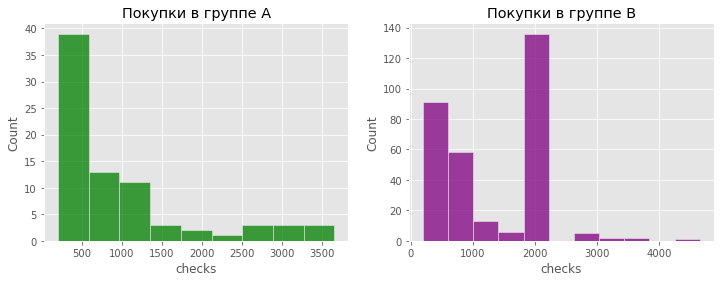

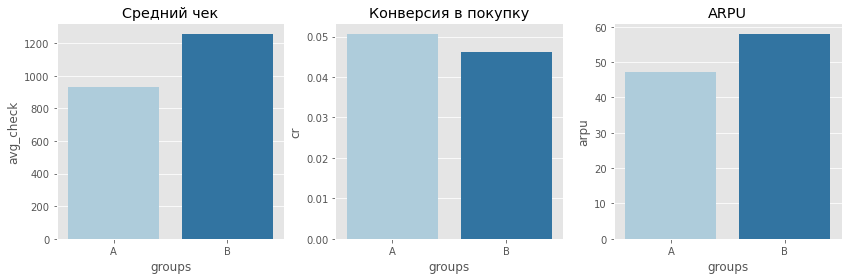

In [68]:
graphics(exp_results, metrics)